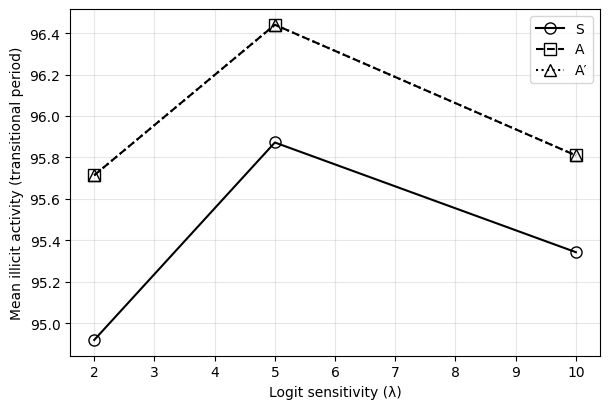

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Formal ABM (same core as Figure 2): pairwise-min weights + cross-border + endogenous P2P friction
# ============================================================

# ----------------------------
# Scenario definitions (same as Figure 2)
# ----------------------------
def scenario_params(scenario: str):
    if scenario == "S":      # synchronized
        Tj = np.array([6, 6, 6, 6, 6, 6])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "A":    # asynchronous
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "Aprime":  # asynchronous + paper compliance
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.015, 0.015])
    else:
        raise ValueError("Unknown scenario")
    return Tj, rho


# ----------------------------
# Pair weights w_{jk} (same as Figure 2 / Appendix A.2.2 revision)
# ----------------------------
def compute_pair_weights(J: int = 6):
    w = np.zeros((J, J))
    weights = {}

    def add(j, k, val):
        weights[(j, k)] = val

    core = [0, 1]
    mid = [2, 3]
    lag = [4, 5]

    add(0, 1, 3.0)
    for j in core:
        for k in mid:
            add(min(j, k), max(j, k), 2.0)
        for k in lag:
            add(min(j, k), max(j, k), 2.0)
    add(2, 3, 1.0)
    for j in mid:
        for k in lag:
            add(min(j, k), max(j, k), 1.0)
    add(4, 5, 0.5)

    total = sum(weights.values())
    for (j, k), val in weights.items():
        w[j, k] = val / total
        w[k, j] = w[j, k]
    return w


# ----------------------------
# International interoperability X_t = sum w_{jk} * 1{adopt both} * min(Rj,Rk)
# ----------------------------
def compute_X(L, R, w):
    X = 0.0
    J = len(L)
    for j in range(J):
        for k in range(j + 1, J):
            if L[j] == 1 and L[k] == 1:
                X += w[j, k] * min(R[j], R[k])
    return float(np.clip(X, 0.0, 1.0))


# ----------------------------
# Logit choice
# ----------------------------
def logit_choice(costs, lam, rng):
    vals = -lam * np.asarray(costs)
    vals -= vals.max()
    probs = np.exp(vals)
    probs /= probs.sum()
    return int(rng.choice(3, p=probs))  # 0=A,1=B,2=C


# ----------------------------
# One simulation run (formal model)
# ----------------------------
def run_one(
    scenario,
    seed,
    *,
    T=60,
    N=100,
    J=6,
    pi_cross=0.35,
    lam=5.0,
    pA0=0.18,
    pB0=0.08,
    pC0=0.02,
    a_s=0.40,
    b_s=0.50,
    F=6.0,
    kA=0.20,
    kB=0.05,
    kC_base=0.80,
    kC_min=0.02,
    kappa=0.10,
):
    rng = np.random.default_rng(seed)

    L = np.zeros(J)   # adoption
    R = np.zeros(J)   # interoperability
    Tj, rho = scenario_params(scenario)
    w = compute_pair_weights(J)

    Y = np.zeros(T)   # successful illicit tx (evade detection)
    D = np.zeros(T)   # detection rate
    sA = np.zeros(T)
    sB = np.zeros(T)
    sC = np.zeros(T)

    N_C_prev = 0

    for t in range(T):
        # (1) update adoption + interoperability
        for j in range(J):
            if t >= Tj[j]:
                L[j] = 1
                R[j] = min(1.0, R[j] + rho[j])

        # (2) sunrise gap
        s_gap = 1.0 - compute_X(L, R, w)

        # (3) endogenous P2P friction (lagged usage)
        kC = max(kC_min, kC_base - kappa * np.log(1 + N_C_prev))

        # (4) cross-border indicator
        cross = rng.random(N) < pi_cross

        # (5) detection probabilities
        pA = np.clip(pA0 - a_s * s_gap * cross, 0.0, 1.0)
        pB = np.clip(pB0 - b_s * s_gap * cross, 0.0, 1.0)
        pC = np.full(N, pC0)

        # (6) expected costs
        costA = pA * F + kA
        costB = pB * F + kB
        costC = pC * F + kC

        # (7) choices
        choices = np.zeros(N, dtype=int)
        for i in range(N):
            choices[i] = logit_choice([costA[i], costB[i], costC[i]], lam, rng)

        # (8) detection outcomes
        p_true = np.where(choices == 0, pA, np.where(choices == 1, pB, pC))
        caught = rng.random(N) < p_true

        Y[t] = N - caught.sum()
        D[t] = caught.mean()
        sA[t] = np.mean(choices == 0)
        sB[t] = np.mean(choices == 1)
        sC[t] = np.mean(choices == 2)

        N_C_prev = int(round(sC[t] * N))

    return Y, D, sA, sB, sC


# ============================================================
# Figure B1: sweep lambda, report mean Y over transition window (t=6..35)
# ============================================================
def mean_illicit_transition(
    scenario: str,
    lam: float,
    *,
    Rruns: int = 200,
    t1: int = 6,
    t2: int = 35,
    seed0: int = 12345,
    T: int = 60,
    N: int = 100,
):
    vals = []
    for r in range(Rruns):
        # Common random numbers across scenarios for a given (lam, r)
        seed = seed0 + 1000 * r
        Y, _, _, _, _ = run_one(scenario, seed=seed, T=T, N=N, lam=lam)
        vals.append(Y[t1 : t2 + 1].mean())
    return float(np.mean(vals))


def make_figure_B1(
    lam_grid=(2, 5, 10),
    *,
    Rruns: int = 200,
    t1: int = 6,
    t2: int = 35,
    seed_base: int = 20250101,
    savepath: str = "Figure_B1_lambda_formal_bw.png",
):
    lam_grid = list(lam_grid)

    Ys, Ya, Yap = [], [], []
    for idx, lam in enumerate(lam_grid):
        seed0 = seed_base + 100000 * idx
        Ys.append(mean_illicit_transition("S", lam, Rruns=Rruns, t1=t1, t2=t2, seed0=seed0))
        Ya.append(mean_illicit_transition("A", lam, Rruns=Rruns, t1=t1, t2=t2, seed0=seed0))
        Yap.append(mean_illicit_transition("Aprime", lam, Rruns=Rruns, t1=t1, t2=t2, seed0=seed0))

    fig, ax = plt.subplots(figsize=(6.2, 4.2))

    # --- Black & white styling (different line styles / markers) ---
    ax.plot(
        lam_grid, Ys,
        color="black", linestyle="-",
        marker="o", markersize=8,
        markerfacecolor="none", markeredgecolor="black",
        label="S",
    )
    ax.plot(
        lam_grid, Ya,
        color="black", linestyle="--",
        marker="s", markersize=8,
        markerfacecolor="none", markeredgecolor="black",
        label="A",
    )
    ax.plot(
        lam_grid, Yap,
        color="black", linestyle=":",
        marker="^", markersize=8,
        markerfacecolor="none", markeredgecolor="black",
        label="A′",
    )

    ax.set_xlabel("Logit sensitivity (λ)")
    ax.set_ylabel("Mean illicit activity (transitional period)")
    ax.grid(alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.close(fig)
    return fig

# ---- run (example) ----
make_figure_B1(lam_grid=(2, 5, 10), Rruns=200, t1=6, t2=35, savepath="Figure_B1_lambda_formal.png")
